In [0]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive'
gdrive_data = '/gdrive/My Drive/my_data'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

use_cuda=True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


epsilons = [0, .05, .1, .15, .2, .25, .3]
batch_size = 1

test_dataset = datasets.MNIST(root='./mnist_data/',
                             train=False,
                             transform=transforms.ToTensor(),
                              download=True)
 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels = 64, kernel_size=8, stride = 2, padding = 3)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels = 128, kernel_size=6, stride = 2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels = 128, kernel_size=5, stride = 1)
        self.dropout2 = nn.Dropout(0.5)
        self.FC1 = nn.Linear(128, 10)
        
        
    def forward(self, x):
        in_size = x.size(0)
        x = self.dropout1(x)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.dropout2(x)
        x = x.view(in_size, -1)
        x = self.FC1(x)

        return x

In [0]:

model = Net()
 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


ckpt_dir = os.path.join(gdrive_root, 'checkpoints')
if not os.path.exists(ckpt_dir):
  print("error...")

ckpt_path = os.path.join(ckpt_dir, 'modelB_ckpt.pt')
if os.path.exists(ckpt_path):
  ckpt = torch.load(ckpt_path)
  try:
    model.load_state_dict(ckpt['model'])
    optimizer.load_state_dict(ckpt['optimizer'])
    best_acc = ckpt['best_acc']
  except RuntimeError as e:
    print('wrong checkpoint')
  else:    
    print('checkpoint is loaded !')
    print('current best accuracy : %.2f' % best_acc)

model.eval()

checkpoint is loaded !
current best accuracy : 0.98


Net(
  (relu): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv1): Conv2d(1, 64, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
  (conv2): Conv2d(64, 128, kernel_size=(6, 6), stride=(2, 2))
  (conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (dropout2): Dropout(p=0.5, inplace=False)
  (FC1): Linear(in_features=128, out_features=10, bias=True)
)

In [0]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [0]:

def test( model, test_loader, epsilon ):
    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        # print( target)

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            # if len(adv_examples) < 1000:
              adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [0]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


Epsilon: 0	Test Accuracy = 9768 / 10000 = 0.9768
Epsilon: 0.05	Test Accuracy = 9341 / 10000 = 0.9341
Epsilon: 0.1	Test Accuracy = 8179 / 10000 = 0.8179
Epsilon: 0.15	Test Accuracy = 5554 / 10000 = 0.5554
Epsilon: 0.2	Test Accuracy = 2420 / 10000 = 0.242
Epsilon: 0.25	Test Accuracy = 928 / 10000 = 0.0928
Epsilon: 0.3	Test Accuracy = 360 / 10000 = 0.036


9768
427
1589
4214
7348
8840
9408


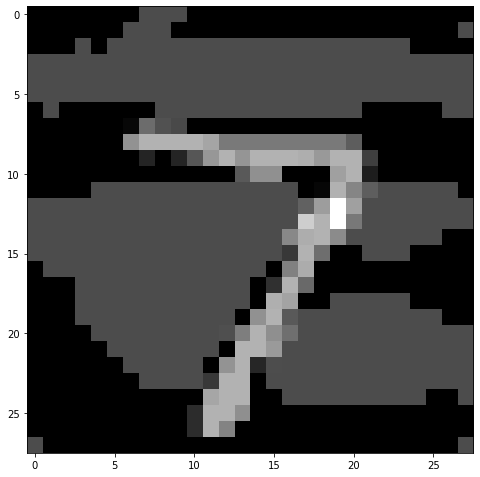

In [0]:

for i in range(len(examples)) :
  print(len(examples[i]))
#print(examples[-1][0])
plt.figure(figsize=(8,10))
plt.imshow(examples[-1][0][-1], cmap="gray")
plt.show()

In [0]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# A Tensor to a PIL image
def imsave(data, save=None): 
  # w, h = 512, 512
  I8 = (((data - data.min()) / (data.max() - data.min())) * 255.9).astype(np.uint8)
  pil_img = Image.fromarray(I8)
  pil_img.save(save)

In [0]:
for i in range(len(epsilons)):
    print(epsilons[i])
    for j in range(20):
        orig,adv,ex = examples[i][j]
        imsave(ex, save=gdrive_data+'/{}_{}to{}.jpg'.format(epsilons[i], orig, adv))

0
0.05
0.1
0.15
0.2
0.25
0.3
